In [1]:
%matplotlib inline
import pandas as pd
import scipy.stats as stats
import random
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.api import qqplot

import warnings
warnings.filterwarnings('ignore')

# File with functions from prior notebook(s)
from myfunk import *

pd.set_option('precision', 2)

/Users/iZbra1/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Load Data

In [2]:
int_data = '../data/processed/data.csv'
data = pd.read_csv(int_data, index_col=0, parse_dates=['date'])
int_data = '../data/processed/dayta.csv'
dayta = pd.read_csv(int_data, index_col=0, parse_dates=['date'])
int_data = '../data/processed/week_data.csv'
week_data = pd.read_csv(int_data, index_col=0, parse_dates=['date'])

## 4. How influential is the weather with both users? Will a nice day be more enticing to use the bike over a rainy day? Does the wind or temperature discourage people to take the bike?

Distribution of the demand according to each day:

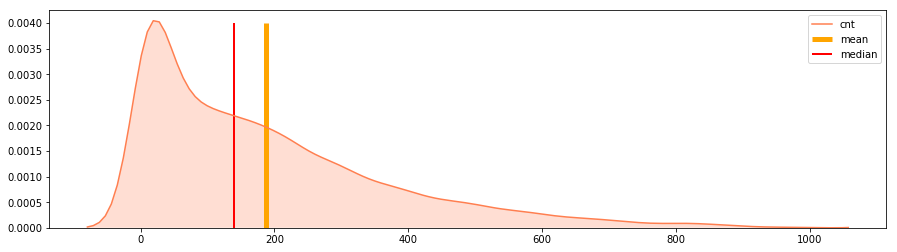

In [3]:
day_data = pd.DataFrame(data.loc[:,'cnt'])
get_distribution_with_center_metrics(day_data)

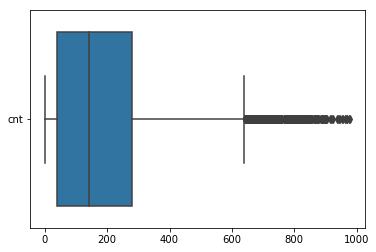

In [4]:
sns.boxplot(data=day_data, orient="h")
plt.show()

*Looks like the demand from every day will be better represented by its distribution's median. Or should there be a* ***log transformation??***

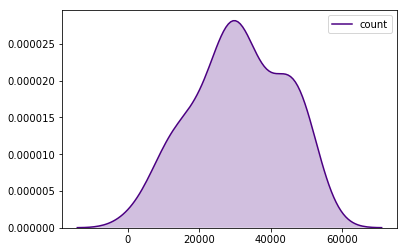

In [5]:
sns.kdeplot(week_data.cnt, shade=True, color="indigo", label='count')

Normalizing the count by week, yields a somewhat normal distribution

In [6]:
print('Skew',week_data.nCnt.skew(),'Kurtosis',week_data.nCnt.kurt())

Skew -0.185194550595 Kurtosis -0.773865114957


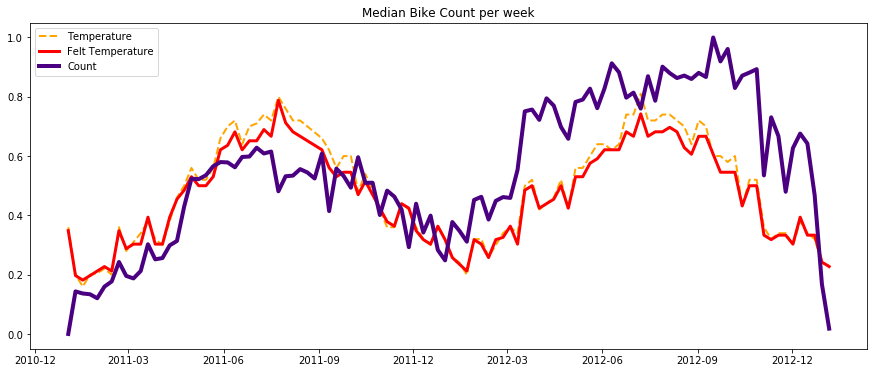

In [7]:
# multiple line plot to compare the temperature with the count
plt.figure(figsize=(15,6))
plt.plot(week_data.index.values, week_data.temp, color='orange', linewidth=2, linestyle='dashed',label='Temperature')
plt.plot(week_data.index.values, week_data.atemp, color='red', linewidth=3, label='Felt Temperature')
plt.plot(week_data.index.values, week_data.nCnt, color='indigo', linewidth=4, label='Count')
plt.title('Median Bike Count per week')
plt.legend()

The count seems to correlate with the temperature and the feels-like temperature. During the 2 years the cycles of the temperature agree with those of the count. 

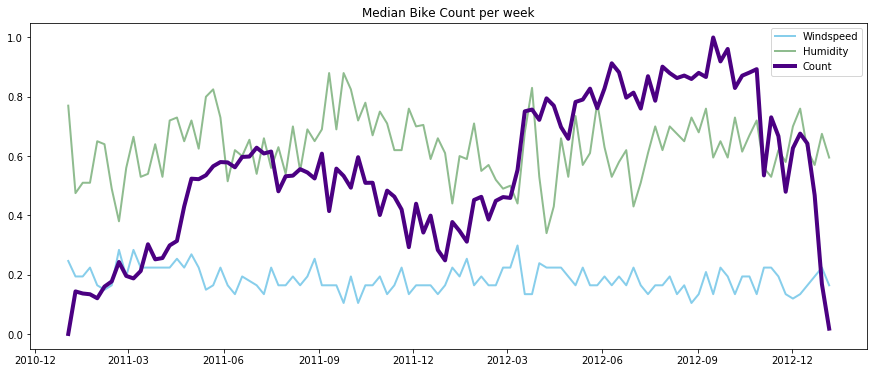

In [8]:
plt.figure(figsize=(15,6))
plt.plot(week_data.index.values, week_data.windspeed, color='skyblue', linewidth=2, label='Windspeed')
plt.plot(week_data.index.values, week_data.humidity, color='darkseagreen', linewidth=2, label='Humidity')
plt.plot(week_data.index.values, week_data.nCnt, color='indigo', linewidth=4, label='Count')
plt.title('Median Bike Count per week')
plt.legend()

It can be seen that almost every negative change in humidity there is an opposite change in demand...
#### *Simple linear regression with **count** as the response and **temperature felt** as the predictor.*

In [9]:
result = sm.OLS.from_formula('nCnt ~ atemp', dayta).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nCnt   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     474.4
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           2.13e-81
Time:                        09:58:05   Log-Likelihood:                 209.94
No. Observations:                 731   AIC:                            -415.9
Df Residuals:                     729   BIC:                            -406.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0703      0.020      3.435      0.001       0.030       0.111
atemp          0.8860      0.041     21.780      0.000       0.806       0.966
==============================================================================
Omnibus:                        7.017   Durbin-Watson:                   0.484
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                5.568
Skew:                           0.116   Prob(JB):                       0.0618
Kurtosis:                       2.641   Cond. No.                         7.45
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
reg_result = pd.DataFrame({'simple reg with atemp':[result.rsquared, result.fvalue, result.aic, result.bic, [result.pvalues]]}).T
reg_result.columns = ['R','f','AIC','BIC', 'p_values']
reg_result

,R,f,AIC,BIC,p_values
simple reg with atemp,0.39,4.7e+02,-4.2e+02,-4.1e+02,"[[0.0006259666151590065, 2.1318914941261025e-81]]"


***The R2 is 39% which is not bad and the p values are almost 0, is it necessary to have an intercept tho?***

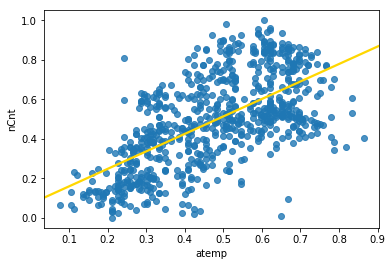

In [11]:
sns.regplot('atemp', 'nCnt', dayta, line_kws = {"color":"gold"}, ci=None)

The temperature felt and the bike demand relationship accounts for **38%** of the variation. 

## What is the predicted number of bikes when theres a temperature that feels like 26C

In [12]:
t = 26
t_min=-16
t_max=50
t_norm = (t-t_min)/(t_max-t_min)
r = result.params['Intercept'] + result.params['atemp'] * t_norm
print('For a temperature of',t,'Celsius (',t_norm,'), the number of bikes out there is ',int(max(week_data.cnt)*r),'(',r,')')

For a temperature of 26 Celsius ( 0.6363636363636364 ), the number of bikes out there is  34893 ( 0.634174655771 )


## What is the predicted number of bikes when theres a temperature that feels like 25C, 30C and 35C

In [13]:
new = pd.DataFrame([[1, 25], [1, 30], [1, 35]], columns=['Intercept', 'atemp'])
# Normalize atemp
t_min=-16
t_max=50
new.atemp = (new.atemp-t_min)/(t_max-t_min)
p = predict(result, new)
# Denormalize
p.fit = p.fit*int(max(dayta.cnt))
p.lower = p.lower*int(max(dayta.cnt))
p.upper = p.upper*int(max(dayta.cnt))
p

,fit,lower,upper
0,5409.22,4626.57,6191.86
1,5994.13,5158.76,6829.49
2,6579.03,5690.95,7467.12


### Residuals and qq plots

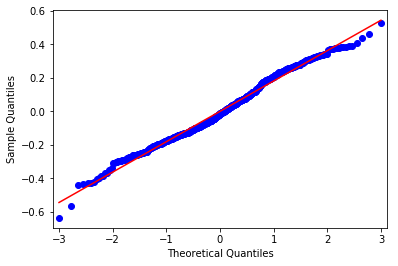

In [14]:
qqplot(result.resid, line='s')
plt.show()

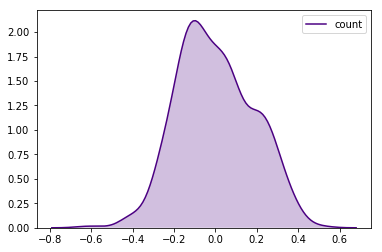

In [15]:
sns.kdeplot(result.resid, shade=True, color="indigo", label='count')

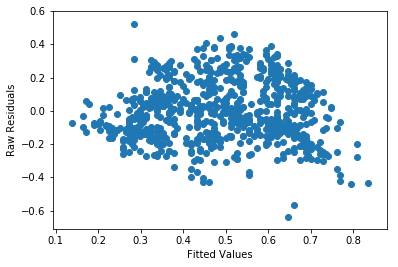

In [16]:
plt.figsize=(18,10)
plt.scatter(result.fittedvalues, result.resid)
plt.ylabel('Raw Residuals')
plt.xlabel('Fitted Values')
plt.show()

The error terms are assumed to be normally distributed, Homoscedastic and Independent!

The residual plot shows that the regression line is good at explaining the relationship between the temperature felt and the demand in bikes. 

The residuals do not contradict the linear assumption

# multiple linear regression:

In [17]:
model = sm.OLS.from_formula('nCnt ~ atemp + temp', dayta)
mlr_temp_atemp = model.fit()
# Add the results to the results dataframe: 
reg_result.loc['mult reg with atemp and temp'] = [mlr_temp_atemp.rsquared, mlr_temp_atemp.fvalue, mlr_temp_atemp.aic, mlr_temp_atemp.bic, [mlr_temp_atemp.pvalues]]

# All columns (except nCnt, which is our response)
model = sm.OLS.from_formula('nCnt ~ temp + atemp + windspeed + humidity', dayta)
mlr_all_var = model.fit()
reg_result.loc['mult reg with all vars'] = [mlr_all_var.rsquared, mlr_all_var.fvalue, mlr_all_var.aic, mlr_all_var.bic, [mlr_all_var.pvalues]]

model = sm.OLS.from_formula('nCnt ~ temp * atemp', dayta)
mlr_tmp_times_atmp = model.fit()
reg_result.loc['mult reg with temp*atemp'] = [mlr_tmp_times_atmp.rsquared, mlr_tmp_times_atmp.fvalue, mlr_tmp_times_atmp.aic, mlr_tmp_times_atmp.bic, [mlr_tmp_times_atmp.pvalues]]

model = sm.OLS.from_formula('nCnt ~ atemp + np.square(atemp)', dayta)
mlr_atmp_sq_atemp = model.fit()
reg_result.loc['mult reg with square(atemp)'] = [mlr_atmp_sq_atemp.rsquared, mlr_atmp_sq_atemp.fvalue, mlr_atmp_sq_atemp.aic, mlr_atmp_sq_atemp.bic, [mlr_atmp_sq_atemp.pvalues]]
reg_result

,R,f,AIC,BIC,p_values
simple reg with atemp,0.39,4.7e+02,-4.2e+02,-4.1e+02,"[[0.0006259666151590065, 2.1318914941261025e-81]]"
mult reg with atemp and temp,0.4,2.4e+02,-4.2e+02,-4e+02,"[[0.0002568118513482815, 0.06182579673327824, ..."
mult reg with all vars,0.45,1.5e+02,-4.9e+02,-4.6e+02,"[[1.1743082723004402e-20, 0.08270556818893149,..."
mult reg with temp*atemp,0.45,2e+02,-4.8e+02,-4.6e+02,"[[1.2087756758239005e-08, 1.1867565450834777e-..."
mult reg with square(atemp),0.44,2.9e+02,-4.7e+02,-4.6e+02,"[[1.4137964665723383e-08, 8.181786376880045e-2..."


***The 3rd model shows the highest fiting potential however this model takes into account all the variables thus a chance of overfitting. Below, the residuals plot is not very convincing at showing a normal distribution as the variance increases with higher predicted values.***

In [18]:
mlr_all_var.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nCnt   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     151.4
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           3.81e-94
Time:                        09:59:18   Log-Likelihood:                 248.48
No. Observations:                 731   AIC:                            -487.0
Df Residuals:                     726   BIC:                            -464.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3871      0.040      9.608      0.000       0.308       0.466
temp           0.4183      0.241      1.738      0.083      -0.054       0.891
atemp          0.4257      0.266      1.603      0.109      -0.096       0.947
windspeed     -0.5486      0.081     -6.736      0.000      -0.708      -0.389
humidity      -0.3188      0.043     -7.386      0.000      -0.404      -0.234
==============================================================================
Omnibus:                       10.052   Durbin-Watson:                   0.429
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                7.592
Skew:                           0.144   Prob(JB):                       0.0225
Kurtosis:                       2.592   Cond. No.                         77.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

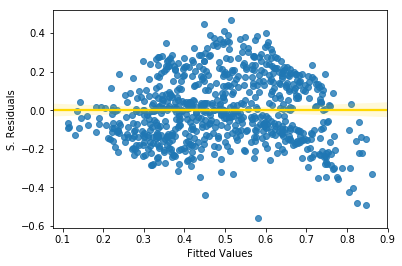

In [19]:
fitted_values = pd.Series(mlr_all_var.fittedvalues, name="Fitted Values")
residuals = pd.Series(mlr_all_var.resid, name="S. Residuals")
#s_residuals = pd.Series(mlr_all_var.resid_pearson, name="S. Residuals Normalized")
sns.regplot(fitted_values, residuals,  fit_reg=True, line_kws = {"color":"gold"})

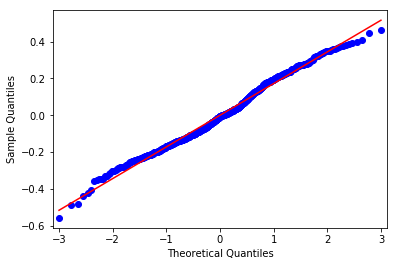

In [20]:
qqplot(mlr_all_var.resid, line='s')
plt.show()

The qqplot above shows that multiple regression with all variables present a somewhat normal distribution

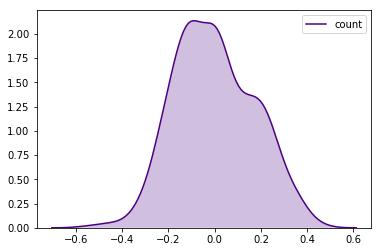

In [21]:
sns.kdeplot(mlr_all_var.resid, shade=True, color="indigo", label='count')

***The 4th and 5th models show promising Rsquared values***

In [22]:
mlr_tmp_times_atmp.rsquared

0.4467884126868783

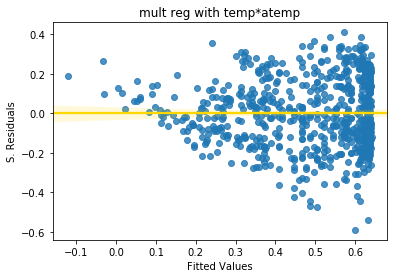

In [23]:
fitted_values = pd.Series(mlr_tmp_times_atmp.fittedvalues, name="Fitted Values")
residuals = pd.Series(mlr_tmp_times_atmp.resid, name="S. Residuals")
#s_residuals = pd.Series(mlr_all_var.resid_pearson, name="S. Residuals Normalized")
sns.regplot(fitted_values, residuals,  fit_reg=True, line_kws = {"color":"gold"})
plt.title('mult reg with temp*atemp')
plt.show()

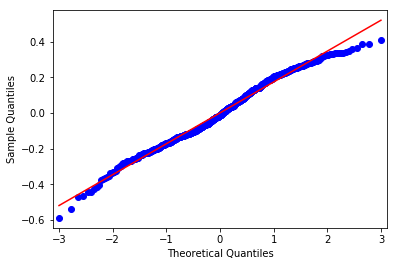

In [24]:
qqplot(mlr_tmp_times_atmp.resid, line='s')
plt.show()

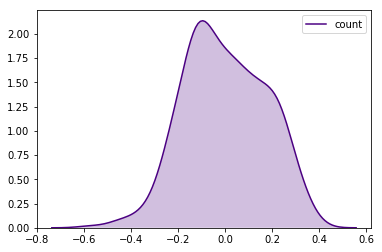

In [25]:
sns.kdeplot(mlr_tmp_times_atmp.resid, shade=True, color="indigo", label='count')

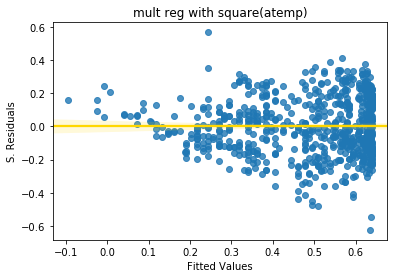

In [26]:
fitted_values = pd.Series(mlr_atmp_sq_atemp.fittedvalues, name="Fitted Values")
residuals = pd.Series(mlr_atmp_sq_atemp.resid, name="S. Residuals")
#s_residuals = pd.Series(mlr_all_var.resid_pearson, name="S. Residuals Normalized")
sns.regplot(fitted_values, residuals,  fit_reg=True, line_kws = {"color":"gold"})
plt.title('mult reg with square(atemp)')

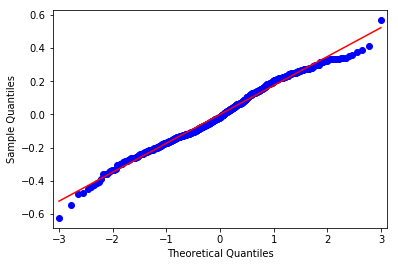

In [27]:
qqplot(mlr_atmp_sq_atemp.resid, line='s')
plt.show()

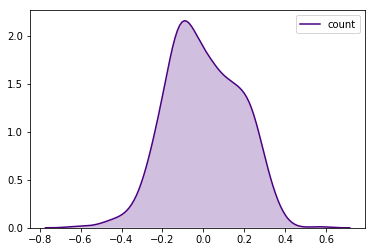

In [28]:
sns.kdeplot(mlr_atmp_sq_atemp.resid, shade=True, color="indigo", label='count')

None of the models above show an adequate fit as their residual plots dont assume a normal distribution, homoscedatic and 

### Subset Selection

In [30]:
mymodels = get_single_models_nCnt_atemp(dayta)

# Subset selection
X = dayta.reset_index().iloc[:,[8,9,10,11]]
y = dayta.reset_index().nCnt

mymodels = get_models(mymodels,X,y)
mymodels

,Method,RSS,model
0,single_reg_with_temp,24.10,<statsmodels.regression.linear_model.Regressio...
1,mlr_all_vars,21.69,<statsmodels.regression.linear_model.Regressio...
2,mlr_temp_times_hum,NaN,<statsmodels.regression.linear_model.Regressio...
3,mlr_tmp_sq_temp,NaN,<statsmodels.regression.linear_model.Regressio...
4,Slow_Subset_selection,24.10,<statsmodels.regression.linear_model.Regressio...
5,Slow_Subset_selection,23.09,<statsmodels.regression.linear_model.Regressio...
6,Slow_Subset_selection,21.76,<statsmodels.regression.linear_model.Regressio...
7,Slow_Subset_selection,21.69,<statsmodels.regression.linear_model.Regressio...
8,Fwd_with_train_and_test,13.05,<statsmodels.regression.linear_model.Regressio...
9,Fwd_with_train_and_test,13.03,<statsmodels.regression.linear_model.Regressio...


Graph every model for each method showing the RSS, adjusted R squared, BIC and AIC and visually pick the best model

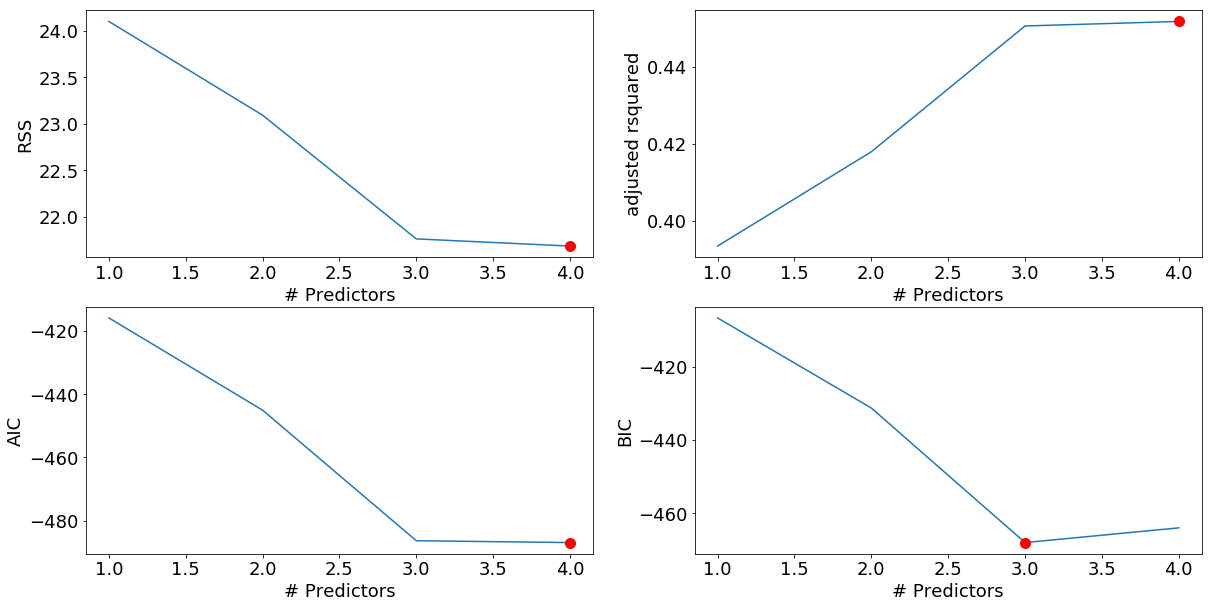

In [56]:
best_models = pd.DataFrame(columns=["Method","RSS", "model"])
# Random subset Selection
models = mymodels.iloc[4:8,-2:].reset_index()
fig = print_optimal_number_predictors(models)
#fig.savefig('BestNoPredictors.png', bbox_inches='tight')

3 or 4 predictors seem to describe the best model

In [32]:
models.loc[3,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nCnt   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     200.6
Date:                Thu, 19 Jul 2018   Prob (F-statistic):           8.87e-95
Time:                        15:58:12   Log-Likelihood:                 247.19
No. Observations:                 731   AIC:                            -486.4
Df Residuals:                     727   BIC:                            -468.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4026      0.039     10.283      0.000       0.326       0.479
temp           0.7998      0.036     22.412      0.000       0.730       0.870
windspeed     -0.5596      0.081     -6.888      0.000      -0.719      -0.400
humidity      -0.3179      0.043     -7.358      0.000      -0.403      -0.233
==============================================================================
Omnibus:                       13.535   Durbin-Watson:                   0.418
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                9.928
Skew:                           0.176   Prob(JB):                      0.00698
Kurtosis:                       2.550   Cond. No.                         17.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It's surprising that atemp is not the best model for 3 predictors!

In [57]:
best_models.loc[0] = ['Randm Subset Selection', models.loc[3].RSS, models.loc[3].model]

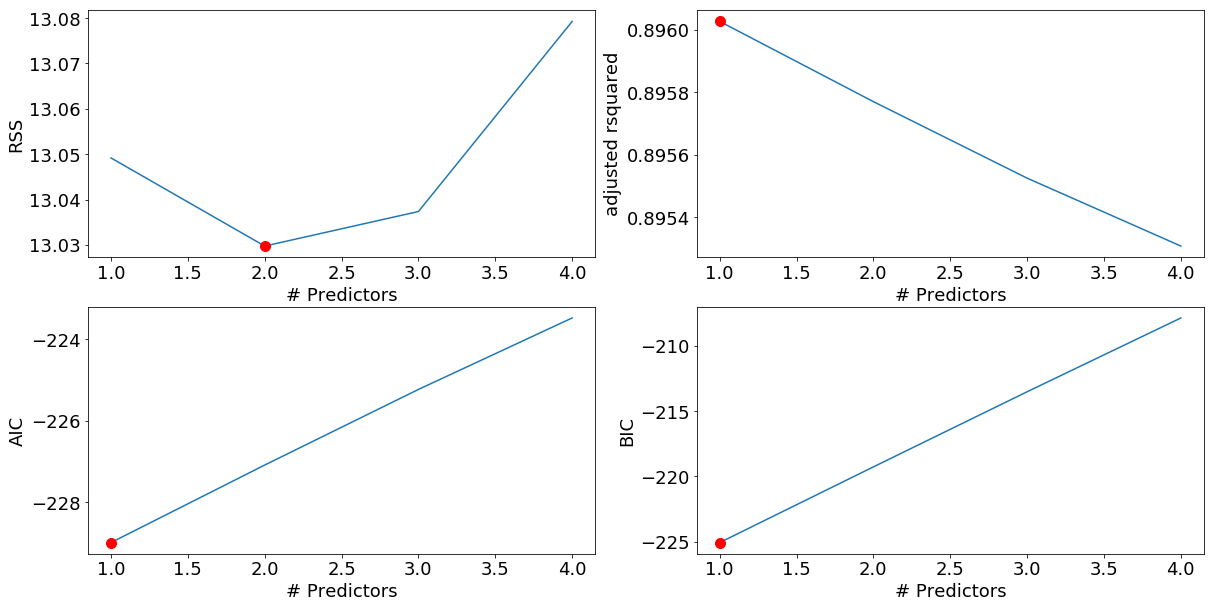

In [58]:
# FWD with train and test
models = mymodels.iloc[8:12,-2:].reset_index()
fig = print_optimal_number_predictors(models)
#fig.savefig('BestNoPredictors.png', bbox_inches='tight')

In [36]:
# 1 or 2 predictors
models.loc[2,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nCnt   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     1578.
Date:                Thu, 19 Jul 2018   Prob (F-statistic):          2.24e-180
Time:                        15:59:16   Log-Likelihood:                 115.54
No. Observations:                 367   AIC:                            -227.1
Df Residuals:                     365   BIC:                            -219.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
atemp          1.0187      0.033     31.055      0.000       0.954       1.083
windspeed     -0.0256      0.081     -0.315      0.753      -0.185       0.134
==============================================================================
Omnibus:                        2.643   Durbin-Watson:                   0.554
Prob(Omnibus):                  0.267   Jarque-Bera (JB):                2.303
Skew:                           0.096   Prob(JB):                        0.316
Kurtosis:                       2.662   Cond. No.                         5.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

However the p value for the 2-predictor model is not significantly low for the windspeed variable

In [59]:
best_models.loc[1] = ['Fwd subset slctn w train & test', models.loc[1].RSS, models.loc[1].model]

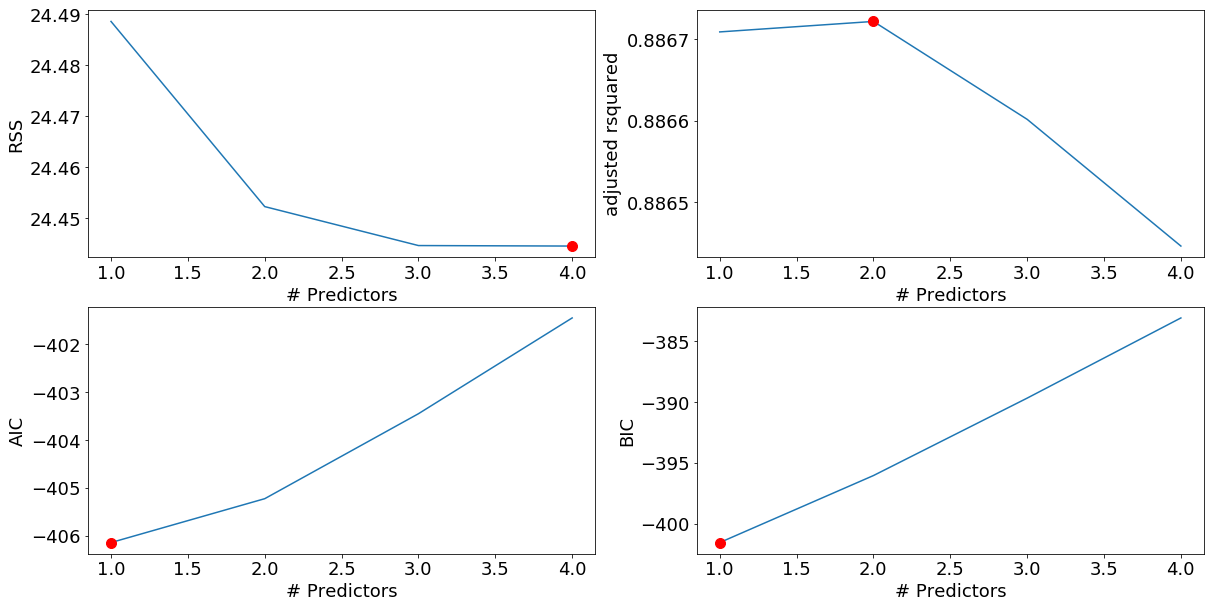

In [61]:
# Fwd_with_full_db
models = mymodels.iloc[12:16,-2:].reset_index()
fig = print_optimal_number_predictors(models)
#fig.savefig('BestNoPredictors.png', bbox_inches='tight')

In [62]:
# 1 predictor
models.loc[2,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nCnt   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     2862.
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        10:24:27   Log-Likelihood:                 204.61
No. Observations:                 731   AIC:                            -405.2
Df Residuals:                     729   BIC:                            -396.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
atemp          1.0402      0.025     41.294      0.000       0.991       1.090
windspeed     -0.0635      0.061     -1.041      0.298      -0.183       0.056
==============================================================================
Omnibus:                        1.720   Durbin-Watson:                   0.492
Prob(Omnibus):                  0.423   Jarque-Bera (JB):                1.631
Skew:                           0.035   Prob(JB):                        0.442
Kurtosis:                       2.779   Cond. No.                         5.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
best_models.loc[2] = ['Fwd subset slctn w full db', models.loc[1].RSS, models.loc[1].model]

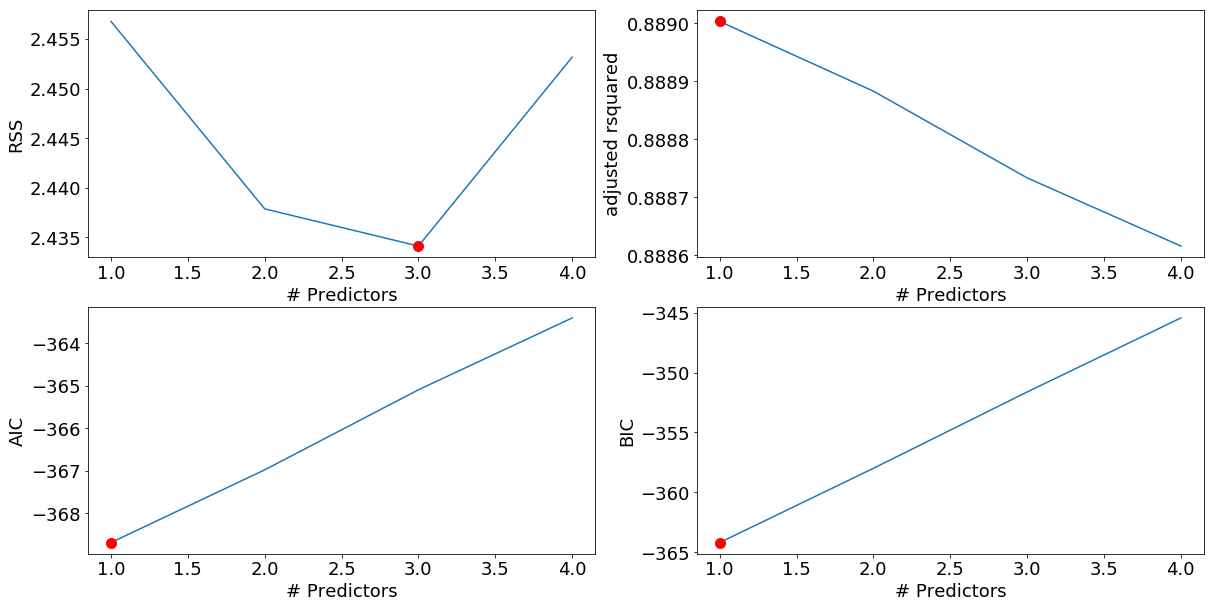

In [68]:
# Cross Validation
models = mymodels.iloc[16:20,-2:].reset_index()
fig = print_optimal_number_predictors(models)
fig.savefig('../reports/img/Q4CVBestNoPredictors.png', bbox_inches='tight')

In [69]:
# 1 or 3
models.loc[1,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nCnt   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     5287.
Date:                Fri, 20 Jul 2018   Prob (F-statistic):          5.37e-317
Time:                        10:28:33   Log-Likelihood:                 185.35
No. Observations:                 660   AIC:                            -368.7
Df Residuals:                     659   BIC:                            -364.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
atemp          1.0231      0.014     72.713      0.000       0.996       1.051
==============================================================================
Omnibus:                        3.085   Durbin-Watson:                   0.488
Prob(Omnibus):                  0.214   Jarque-Bera (JB):                2.694
Skew:                           0.069   Prob(JB):                        0.260
Kurtosis:                       2.719   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
best_models.loc[3] = ['Cross Validation', models.loc[1].RSS, models.loc[1].model]
best_models

,Method,RSS,model
0,Randm Subset Selection,21.76,<statsmodels.regression.linear_model.Regressio...
1,Fwd subset slctn w train & test,13.05,<statsmodels.regression.linear_model.Regressio...
2,Fwd subset slctn w full db,24.49,<statsmodels.regression.linear_model.Regressio...
3,Cross Validation,2.46,<statsmodels.regression.linear_model.Regressio...


Cross validation is the best method to choose a model that has comparably lower values of RSS and in this case the best model is the single predictor one. **Temperature felt is the best predictor.** 

In [73]:
best_models.loc[3].model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nCnt   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     5287.
Date:                Fri, 20 Jul 2018   Prob (F-statistic):          5.37e-317
Time:                        10:34:49   Log-Likelihood:                 185.35
No. Observations:                 660   AIC:                            -368.7
Df Residuals:                     659   BIC:                            -364.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
atemp          1.0231      0.014     72.713      0.000       0.996       1.051
==============================================================================
Omnibus:                        3.085   Durbin-Watson:                   0.488
Prob(Omnibus):                  0.214   Jarque-Bera (JB):                2.694
Skew:                           0.069   Prob(JB):                        0.260
Kurtosis:                       2.719   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

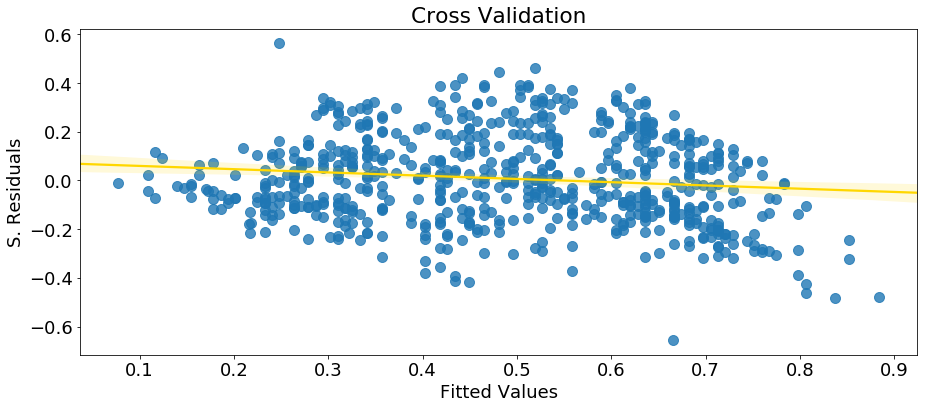

In [77]:
fig = plt.figure(figsize=(15,6))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})
fitted_values = pd.Series(best_models.loc[3,'model'].fittedvalues, name="Fitted Values")
residuals = pd.Series(best_models.loc[3,'model'].resid, name="S. Residuals")
sns.regplot(fitted_values, residuals,  fit_reg=True, line_kws = {"color":"gold"})
plt.title(best_models.loc[3,'Method'])
plt.show()
fig.savefig('../reports/img/Q4CVResidualPlot.png', bbox_inches='tight')

It's fair to say that from the figure above there's little variance on the high and low predicted values. 

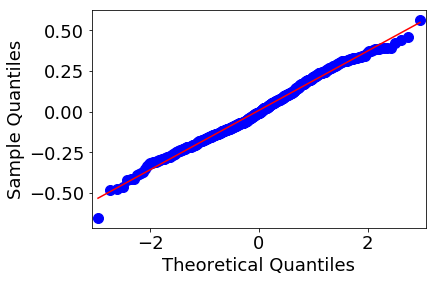

In [80]:
fig = plt.figure(figsize=(15,6))
fig = qqplot(best_models.loc[3,'model'].resid, line='s')
plt.show()
fig.savefig('../reports/img/Q4CVqqPlot.png', bbox_inches='tight')

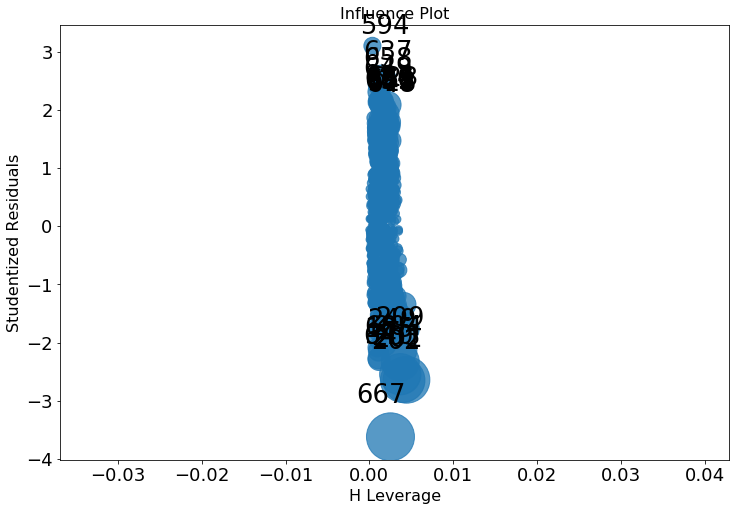

In [46]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(best_models.loc[3,'model'],ax=ax)

# Polynomials

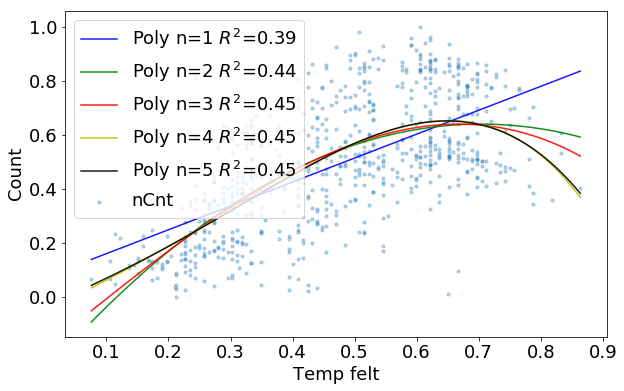

In [83]:
# plot lstat (% lower status of the population) against median value
fig = plt.figure(figsize=(6 * 1.618, 6))
plt.scatter(dayta.atemp, dayta.nCnt, s=10, alpha=0.3)
plt.xlabel('Temp felt')
plt.ylabel('Count')

# points linearlyd space on lstats
x = pd.DataFrame({'atemp': np.linspace(dayta.atemp.min(), dayta.atemp.max(), 100)})

# 1-st order polynomial
poly_1 = smf.ols(formula='nCnt ~ 1 + atemp', data=dayta).fit()
plt.plot(x.atemp, poly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % poly_1.rsquared, 
         alpha=0.9)

# 2-nd order polynomial
poly_2 = smf.ols(formula='nCnt ~ 1 + I(atemp) + I(atemp ** 2.0)', data=dayta).fit()
plt.plot(x.atemp, poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % poly_2.rsquared, 
         alpha=0.9)

# 3-rd order polynomial
poly_3 = smf.ols(formula='nCnt ~ 1 + atemp - I(atemp ** 2.0) + I(atemp ** 3.0)', data=dayta).fit()
plt.plot(x.atemp, poly_3.predict(x), 'r-', alpha=0.9,
         label='Poly n=3 $R^2$=%.2f' % poly_3.rsquared)

# 4-th order polynomial
poly_4 = smf.ols(formula='nCnt ~ 1 + atemp - I(atemp ** 2.0) + I(atemp ** 3.0) + I(atemp ** 4.0)', data=dayta).fit()
plt.plot(x.atemp, poly_4.predict(x), 'y-', alpha=0.9,
         label='Poly n=4 $R^2$=%.2f' % poly_4.rsquared)

# 5-th order polynomial
poly_5 = smf.ols(formula='nCnt ~ 1 + I(atemp) - I(atemp ** 2.0) + I(atemp ** 3.0) + I(atemp ** 4.0) + I(atemp ** 5.0)', data=dayta).fit()
plt.plot(x.atemp, poly_5.predict(x), 'k-', alpha=0.9,
         label='Poly n=5 $R^2$=%.2f' % poly_5.rsquared)

plt.legend()
plt.show()
fig.savefig('../reports/img/Q4Polynomials.png', bbox_inches='tight')

In [48]:
print(sm.stats.anova_lm(poly_1, poly_2, poly_3, poly_4, poly_5, typ=1))

   df_resid    ssr  df_diff   ss_diff      F    Pr(>F)
0     729.0  24.10      0.0       NaN    NaN       NaN
1     728.0  22.23      1.0  1.87e+00  62.13  1.18e-14
2     728.0  22.02     -0.0  2.15e-01   -inf       NaN
3     727.0  21.82      1.0  1.96e-01   6.52  1.09e-02
4     726.0  21.82      1.0  1.44e-03   0.05  8.27e-01


The p value from model 3 and 4 is the highest suggesting either model is a better fit than the rest. 

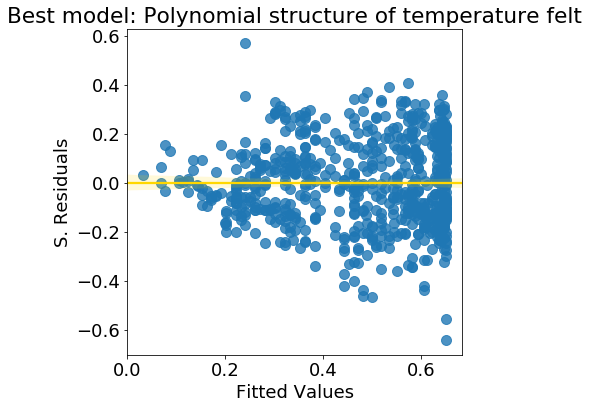

In [49]:
fig = plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})
fitted_values = pd.Series(poly_4.fittedvalues, name="Fitted Values")
residuals = pd.Series(poly_4.resid, name="S. Residuals")
sns.regplot(fitted_values, residuals,  fit_reg=True, line_kws = {"color":"gold"})
plt.title('Best model: Polynomial structure of temperature felt')
plt.show()

fig.savefig('Q4CVBestModelsResults.png', bbox_inches='tight')

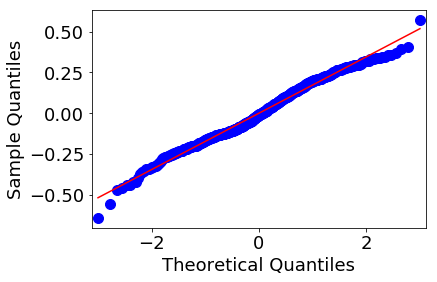

In [50]:
fig = plt.figure(figsize=(10,6))
qqplot(poly_4.resid, line='s')
plt.show()

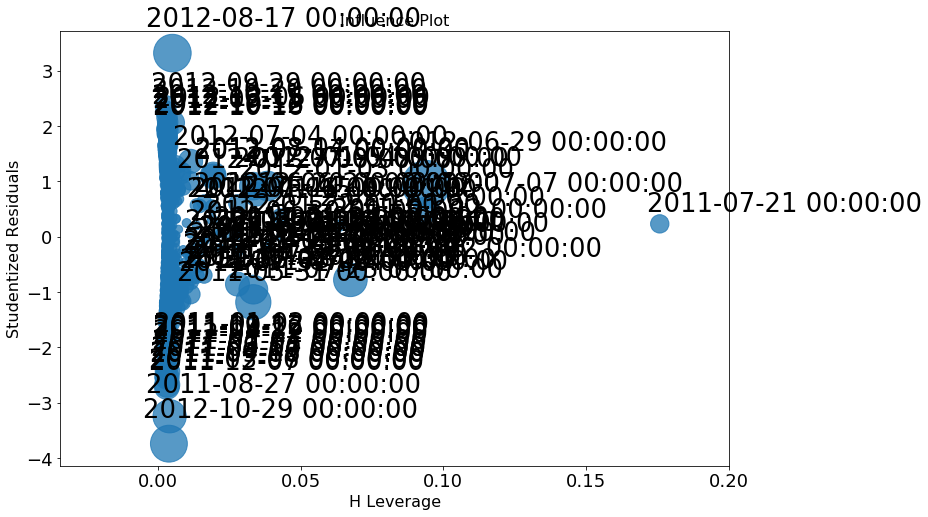

In [51]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(poly_4,ax=ax)